In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_11_modif_top10ventas_nov.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo,year,month
0,11,1,AC,SVE,VENTA COMPUTARIZADA,18112965,0,2018-11-18 07:39:58,PIERNA MUSLO OFERTA,KG,0.0000,1.3800,19.3200,12.8800,12.8800,2.7756,TROZADO,2018,11
1,11,1,AC,SVE,VENTA COMPUTARIZADA,18112956,1,2018-11-18 07:29:54,PIERNA MUSLO OFERTA,KG,0.0000,1.2006,16.8360,12.8800,12.8800,2.4187,TROZADO,2018,11
2,11,1,AC,SVE,VENTA COMPUTARIZADA,18112954,0,2018-11-18 07:27:44,PIERNA MUSLO OFERTA,KG,0.0000,5.5200,77.2800,12.8800,12.8800,11.1035,TROZADO,2018,11
3,11,1,AC,SVE,VENTA COMPUTARIZADA,18112950,1,2018-11-18 07:22:43,CUELLO,KG,0.0000,0.6026,2.1160,3.2200,3.2200,0.3036,TROZADO,2018,11
4,11,1,AC,SVE,VENTA COMPUTARIZADA,18112946,3,2018-11-18 07:18:22,CUELLO,KG,0.0000,0.9706,3.4040,3.2200,3.2200,0.4894,TROZADO,2018,11


In [ ]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
month                             int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [ ]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-139-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [ ]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] <= '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[df_todo['FechaMovimiento'] < '2023-11-01']

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (286438, 4)
sin noviembre  (281330, 4)
noviembre 2023  (5108, 4)


In [ ]:
df_noviembre.head()

,NombreProducto,FechaMovimiento,MontoBase,year
60400,CUELLO,2023-11-01 07:34:33,124.6140,2023
60399,RABADILLA,2023-11-01 07:36:36,14.1496,2023
281789,POLLO CON MENUDENCIA H-C,2023-11-01 07:36:36,30.1888,2023
60398,PIERNA MUSLO,2023-11-01 07:38:38,189.1888,2023
281788,POLLO CON MENUDENCIA H-C,2023-11-01 07:39:29,96.2624,2023


In [ ]:
df_noviembre.tail()

,NombreProducto,FechaMovimiento,MontoBase,year
286633,CORAZON,2023-11-30 11:24:16,12.9050,2023
286632,CORAZON,2023-11-30 11:31:25,12.9050,2023
286631,CORAZON,2023-11-30 11:35:28,27.7502,2023
286630,CORAZON,2023-11-30 11:46:32,17.4262,2023
286629,CORAZON,2023-11-30 11:50:16,15.4860,2023


In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_suma_sin_2020 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  9332.5070
1      2023-11-02  9630.4511
2      2023-11-03  7936.0575
3      2023-11-04  8382.5270
4      2023-11-05  5534.4785
5      2023-11-06 10146.2390
6      2023-11-07  9024.6372
7      2023-11-08  6956.9346
8      2023-11-09  7042.5589
9      2023-11-10  5251.4783
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


# PROPHET


In [ ]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
60400                     CUELLO      2023-11-01   124.6140  2023
60399                  RABADILLA      2023-11-01    14.1496  2023
281789  POLLO CON MENUDENCIA H-C      2023-11-01    30.1888  2023
60398               PIERNA MUSLO      2023-11-01   189.1888  2023
281788  POLLO CON MENUDENCIA H-C      2023-11-01    96.2624  2023
...                          ...             ...        ...   ...
286633                   CORAZON      2023-11-30    12.9050  2023
286632                   CORAZON      2023-11-30    12.9050  2023
286631                   CORAZON      2023-11-30    27.7502  2023
286630                   CORAZON      2023-11-30    17.4262  2023
286629                   CORAZON      2023-11-30    15.4860  2023

[5108 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

In [ ]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_sin_2020 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year == 2020)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print(df_todo_hasta_nov_sin_2020.shape)

NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
          NombreProducto FechaMovimiento  MontoBase  year
718  PIERNA MUSLO OFERTA      2018-11-01    19.9640  2018
717            RABADILLA      2018-11-01    17.9400  2018
716            RABADILLA      2018-11-01    10.7640  2018
715  PIERNA MUSLO OFERTA      2018-11-01    38.6400  2018
714  PIERNA MUSLO OFERTA      2018-11-01   338.7440  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
------------------------------
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
NombreProducto      object
FechaMovimiento     object
MontoBase          floa

<ipython-input-147-9da9706da809>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date


In [ ]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = pd.to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = pd.to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_sin_2020_prophet = df_todo_hasta_nov_sin_2020.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_sin_2020_prophet = df_todo_hasta_nov_sin_2020_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_sin_2020_prophet.head)
print(df_todo_hasta_nov_sin_2020_prophet.shape)

<bound method NDFrame.head of               ds          y
0     2018-11-01  1919.1250
1     2018-11-02  1488.3740
2     2018-11-03  8341.7180
3     2018-11-04  6940.9740
4     2018-11-05  6447.0630
...          ...        ...
1407  2023-10-27  7760.7466
1408  2023-10-28 12445.1841
1409  2023-10-29  9805.2984
1410  2023-10-30 13719.8369
1411  2023-10-31  8297.2566

[1412 rows x 2 columns]>
(1412, 2)


### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [ ]:
# # Obtener los 10 productos más vendidos
# top_10_products = df['NombreProducto'].value_counts().head(10).index

# # Crear un diccionario para almacenar los DataFrames divididos
# dfs_de_productos = {}
# dfs_de_productos_sin_2020 = {}

# # Iterar sobre los productos y dividir el DataFrame
# for product in top_10_products:
#     # Crear un DataFrame para el producto actual
#     product_df = df_todo[df_todo['NombreProducto'] == product].copy()
#     product_df_sin_2020 = df_todo_hasta_nov_sin_2020[df_todo_hasta_nov_sin_2020['NombreProducto'] == product].copy()

#     # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
#     # product_df.set_index('FechaMovimiento', inplace=True)
#     # product_df_sin_2020.set_index('FechaMovimiento', inplace=True)
#     product_df.set_index('FechaMovimiento', inplace=True)
#     product_df_sin_2020.set_index('FechaMovimiento', inplace=True)


#     # Almacenar el DataFrame en el diccionario
#     dfs_de_productos[product] = product_df
#     dfs_de_productos_sin_2020[product] = product_df_sin_2020

# # Ahora, dfs_by_product contiene 10 DataFrames, uno por cada producto
# # Puedes acceder a un DataFrame específico utilizando su nombre de producto como clave
# # Por ejemplo, dfs_by_product['Nombre_Producto_1']

In [ ]:
# print(dfs_de_productos)

In [ ]:
# print(dfs_de_productos_sin_2020)

In [ ]:
# unique_products = df['NombreProducto'].unique()
# print(unique_products)

In [ ]:
# for i, df_product in enumerate(dfs_de_productos):
#     print(f"DataFrame {i + 1} - Tipos de Datos:")
#     print(dfs_de_productos[df_product].dtypes)
#     print("=" * 30)

## Predecir cada uno de los 10 productos mas vendidos

In [ ]:
# # Crear un diccionario para almacenar las predicciones
# predicciones_por_producto = {}

# # Seleccionar el rango de fechas que quieres mostrar (últimos 2-3 meses)
# fecha_inicio_str = '2023-09-01'  # Ajusta según tus necesidades
# fecha_fin_str = '2023-11-30'    # Ajusta según tus necesidades
# # Convertir las fechas a objetos datetime
# fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
# fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# # Iterar sobre los DataFrames de productos y aplicar Prophet
# for product, product_df in dfs_de_productos.items():
#     # Restaurar el índice para asegurarse de que 'ds' sea una columna
#     product_df.reset_index(inplace=True)

#     # Crear y ajustar el modelo de Prophet
#     modelo = Prophet()
#     modelo.fit(product_df)

#     # Crear un DataFrame con fechas futuras para hacer la predicción
#     futuro = modelo.make_future_dataframe(periods=30)  # Asumiendo que quieres prever 30 días adicionales

#     # Hacer la predicción
#     prediccion = modelo.predict(futuro)

#     # Almacenar la predicción en el diccionario
#     predicciones_por_producto[product] = prediccion


# # Visualizar la predicción con límites ajustados
#     fig = modelo.plot(prediccion)
# # Aplicar límites al eje x
#     plt.xlim([fecha_inicio, fecha_fin])
# # Añadir título al gráfico
#     plt.title(f'Predicción de Ventas para {product} (Últimos 2-3 meses y Predicción de 30 días)')
# # Mostrar el gráfico
#     plt.show()

#     # # Visualizar la predicción
#     # fig = modelo.plot(prediccion)
#     # plt.title(f'Predicción de Ventas para {product}')
#     # plt.show()

In [ ]:
# # Crear un diccionario para almacenar las predicciones
# predicciones_por_producto = {}


# # Seleccionar el rango de fechas que quieres mostrar (últimos 2-3 meses)
# fecha_inicio_str = '2023-09-01'  # Ajusta según tus necesidades
# fecha_fin_str = '2023-11-30'    # Ajusta según tus necesidades
# # Convertir las fechas a objetos datetime
# fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
# fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')


# # Iterar sobre los DataFrames de productos y aplicar Prophet
# for product, product_df in dfs_de_productos_sin_2020.items():
#     # Restaurar el índice para asegurarse de que 'ds' sea una columna
#     product_df.reset_index(inplace=True)

#     # Crear y ajustar el modelo de Prophet
#     modelo = Prophet()
#     modelo.fit(product_df)

#     # Crear un DataFrame con fechas futuras para hacer la predicción
#     futuro = modelo.make_future_dataframe(periods=30)  # Asumiendo que quieres prever 30 días adicionales

#     # Hacer la predicción
#     prediccion = modelo.predict(futuro)

#     # Almacenar la predicción en el diccionario
#     predicciones_por_producto[product] = prediccion

# # Visualizar la predicción con límites ajustados
#     fig = modelo.plot(prediccion)
# # Aplicar límites al eje x
#     plt.xlim([fecha_inicio, fecha_fin])
# # Añadir título al gráfico
#     plt.title(f'Predicción de Ventas para {product} (Últimos 2-3 meses y Predicción de 30 días)')
# # Mostrar el gráfico
#     plt.show()

#     # # Visualizar la predicción
#     # fig = modelo.plot(prediccion)
#     # plt.title(f'Predicción de Ventas para {product}')
#     # plt.show()

## Predicciones con y sin 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr8m676u/ahputhrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr8m676u/2a9hjayx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94746', 'data', 'file=/tmp/tmpzr8m676u/ahputhrb.json', 'init=/tmp/tmpzr8m676u/2a9hjayx.json', 'output', 'file=/tmp/tmpzr8m676u/prophet_modeli33c8y8z/prophet_model-20231222222435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr

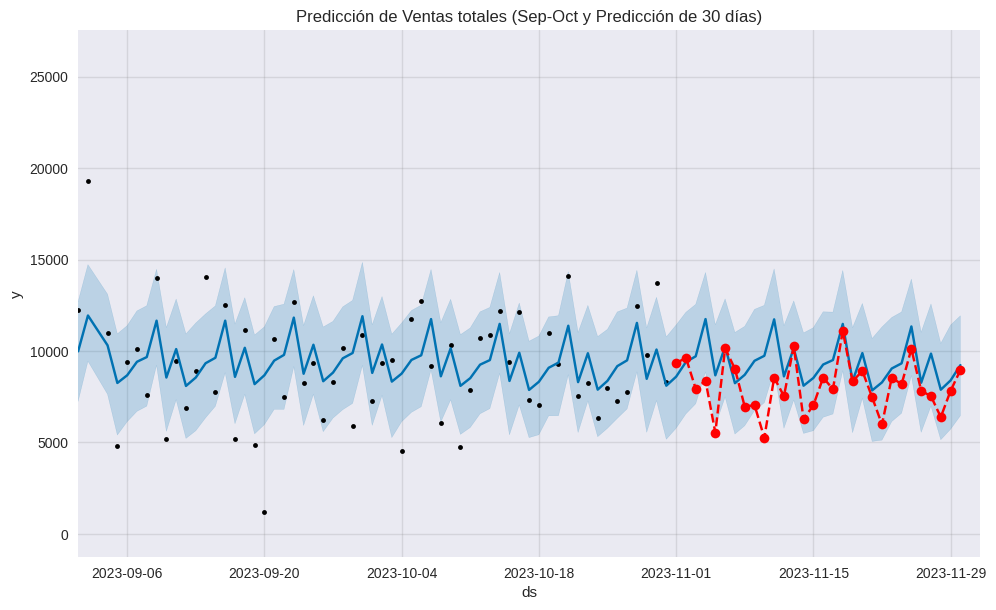

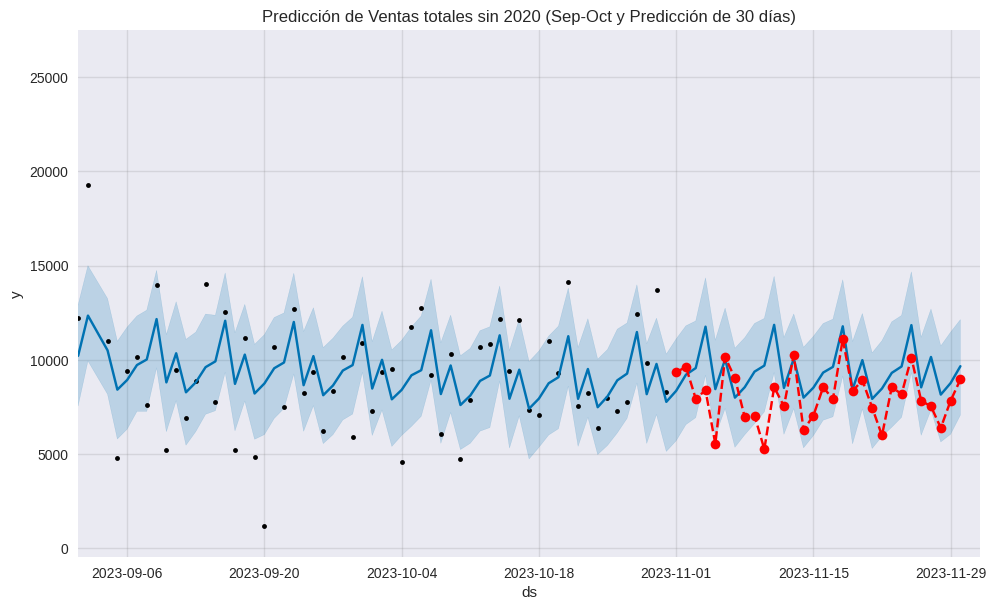

prediccion con todos los valores               ds       yhat
1699 2023-11-01  8595.6330
1700 2023-11-02  9399.1706
1701 2023-11-03  9711.9055
1702 2023-11-04 11745.6439
1703 2023-11-05  8671.9549
1704 2023-11-06 10248.9363
1705 2023-11-07  8241.8131
1706 2023-11-08  8699.8866
1707 2023-11-09  9465.6735
1708 2023-11-10  9737.9864
1709 2023-11-11 11729.7674
1710 2023-11-12  8613.7947
1711 2023-11-13 10149.4205
1712 2023-11-14  8103.1374
1713 2023-11-15  8525.4969
1714 2023-11-16  9260.2161
1715 2023-11-17  9507.2278
1716 2023-11-18 11480.4838
1717 2023-11-19  8353.6343
1718 2023-11-20  9886.7415
1719 2023-11-21  7846.8247
1720 2023-11-22  8284.7617
1721 2023-11-23  9044.3836
1722 2023-11-24  9325.5165
1723 2023-11-25 11341.7833
1724 2023-11-26  8266.2855
1725 2023-11-27  9858.3243
1726 2023-11-28  7883.9596
1727 2023-11-29  8392.9287
1728 2023-11-30  9227.7635
prediccion sin el 2020               ds       yhat
1412 2023-11-01  8351.0707
1413 2023-11-02  9208.3682
1414 2023-11-03  9562.01

In [ ]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_sin_2020_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales sin 2020 (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()


# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# plt.show()

# fig = modelo2.plot(prediccion2)
# plt.show()

## EVALUACION
Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

In [ ]:
# # Convertir la columna 'ds' a datetime64 en el DataFrame de predicciones
# valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds']).dt.date

# # Asegurarse de que la columna 'ds' en df_noviembre_agregado también sea de tipo datetime64
# df_noviembre_prophet['ds'] = pd.to_datetime(df_noviembre_prophet['ds']).dt.date

# # print("valores reales de noviembre")
# # print(df_noviembre_agregado)
# # print(df_noviembre_agregado.dtypes)
# # print("valores predichos de noviembre")
# # print(valores_prediccion1)
# # print(valores_prediccion1.dtypes)

# # Unir los DataFrames por la columna 'ds' para tener los valores reales y las predicciones en un solo DataFrame
# resultados = pd.merge(df_noviembre_prophet, valores_prediccion1, on='ds', how='inner')

# print(resultados)

# # Calcular el RMSE
# rmse = np.sqrt(mean_squared_error(resultados['y'], resultados['yhat']))

# # Calcular el MAPE
# mape = np.mean(np.abs((resultados['y'] - resultados['yhat']) / resultados['y'])) * 100

# # Imprimir los resultados
# print(f"RMSE: {rmse}")
# print(f"MAPE: {mape}%")


In [ ]:
# # Convertir la columna 'ds' a datetime64 en el DataFrame de predicciones
# valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds']).dt.date

# # Asegurarse de que la columna 'ds' en df_noviembre_agregado también sea de tipo datetime64
# df_noviembre_prophet['ds'] = pd.to_datetime(df_noviembre_prophet['ds']).dt.date

# # print("valores reales de noviembre")
# # print(df_noviembre_agregado)
# # print(df_noviembre_agregado.dtypes)
# # print("valores predichos de noviembre")
# # print(valores_prediccion1)
# # print(valores_prediccion1.dtypes)

# # Unir los DataFrames por la columna 'ds' para tener los valores reales y las predicciones en un solo DataFrame
# resultados = pd.merge(df_noviembre_prophet, valores_prediccion2, on='ds', how='inner')

# print(resultados)

# # Calcular el RMSE
# rmse = np.sqrt(mean_squared_error(resultados['y'], resultados['yhat']))

# # Calcular el MAPE
# mape = np.mean(np.abs((resultados['y'] - resultados['yhat']) / resultados['y'])) * 100

# # Imprimir los resultados
# print(f"RMSE: {rmse}")
# print(f"MAPE: {mape}%")


evaluacion con 2020

In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_suma_sin_2020 = df_noviembre_sumaT.copy()

In [ ]:
# print(valores_prediccion1.describe)
# print(df_noviembre_sumaT.shape)

In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = pd.merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  9332.5070       8595.6330
1       2023-11-02  9630.4511       9399.1706
2       2023-11-03  7936.0575       9711.9055
3       2023-11-04  8382.5270      11745.6439
4       2023-11-05  5534.4785       8671.9549
5       2023-11-06 10146.2390      10248.9363
6       2023-11-07  9024.6372       8241.8131
7       2023-11-08  6956.9346       8699.8866
8       2023-11-09  7042.5589       9465.6735
9       2023-11-10  5251.4783       9737.9864
10      2023-11-11  8545.1866      11729.7674
11      2023-11-12  7537.8548       8613.7947
12      2023-11-13 10254.5751      10149.4205
13      2023-11-14  6272.3680       8103.1374
14      2023-11-15  7034.2938       8525.4969
15      2023-11-16  8544.7383       9260.2161
16      2023-11-17  7913.3417       9507.2278
17      2023-11-18 11101.9140      11480.4838
18      2023-11-19  8343.8159       8353.6343
19      2023-11-20  8914.5126       9886.7415
20      2023-11-21  7464.1983     

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 3078152.135372517
MAE is : 1359.817739524297
R2 is : -0.5646973832517912

--------------------
RMSE is : 1754.4663391962006
MAPE is : 19.19058256254281 %


evaluacion sin 2020

In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_suma_sin_2020['FechaMovimiento'] = pd.to_datetime(df_noviembre_suma_sin_2020['FechaMovimiento'])
valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_suma_sin_2020 = pd.merge(df_noviembre_suma_sin_2020, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_suma_sin_2020.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_suma_sin_2020.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_suma_sin_2020.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  9332.5070       8351.0707
1       2023-11-02  9630.4511       9208.3682
2       2023-11-03  7936.0575       9562.0162
3       2023-11-04  8382.5270      11759.6584
4       2023-11-05  5534.4785       8446.6696
5       2023-11-06 10146.2390      10031.9297
6       2023-11-07  9024.6372       7992.9822
7       2023-11-08  6956.9346       8547.3578
8       2023-11-09  7042.5589       9373.1661
9       2023-11-10  5251.4783       9693.3231
10      2023-11-11  8545.1866      11856.5347
11      2023-11-12  7537.8548       8509.2911
12      2023-11-13 10254.5751      10061.6130
13      2023-11-14  6272.3680       7992.1812
14      2023-11-15  7034.2938       8519.6290
15      2023-11-16  8544.7383       9323.1053
16      2023-11-17  7913.3417       9626.4725
17      2023-11-18 11101.9140      11779.2631
18      2023-11-19  8343.8159       8428.6489
19      2023-11-20  8914.5126       9985.1658


In [ ]:
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 3290456.396026234
MAE is : 1482.8240920209669
R2 is : -0.6726166499055417

--------------------
RMSE is : 1813.9615199960097
MAPE is : 20.550141713454092 %


# LSTM


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

          NombreProducto FechaMovimiento  MontoBase  year
718  PIERNA MUSLO OFERTA      2018-11-01    19.9640  2018
717            RABADILLA      2018-11-01    17.9400  2018
716            RABADILLA      2018-11-01    10.7640  2018
715  PIERNA MUSLO OFERTA      2018-11-01    38.6400  2018
714  PIERNA MUSLO OFERTA      2018-11-01   338.7440  2018
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
(281330, 4)
---------------   PROPHET   ---------------
           ds         y
0  2018-11-01 1919.1250
1  2018-11-02 1488.3740
2  2018-11-03 8341.7180
3  2018-11-04 6940.9740
4  2018-11-05 6447.0630
ds     object
y     float64
dtype: object
(1699, 2)


In [ ]:
df_lstm = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

df_lstm_sin_2020 = df_todo_hasta_nov_sin_2020_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

In [ ]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = pd.to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm['DayOW'] = df_lstm.index.dayofweek
df_lstm['Month'] = df_lstm.index.month
df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1919.1250      3     11  2018
2018-11-02       1488.3740      4     11  2018
2018-11-03       8341.7180      5     11  2018
2018-11-04       6940.9740      6     11  2018
2018-11-05       6447.0630      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       7760.7466      4     10  2023
2023-10-28      12445.1841      5     10  2023
2023-10-29       9805.2984      6     10  2023
2023-10-30      13719.8369      0     10  2023
2023-10-31       8297.2566      1     10  2023

[1699 rows x 4 columns]


In [ ]:
print(df_lstm)
print(df_lstm.dtypes)
print(df_todo_hasta_nov_prophet)
print(df_todo_hasta_nov_prophet.dtypes)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1919.1250      3     11  2018
2018-11-02       1488.3740      4     11  2018
2018-11-03       8341.7180      5     11  2018
2018-11-04       6940.9740      6     11  2018
2018-11-05       6447.0630      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       7760.7466      4     10  2023
2023-10-28      12445.1841      5     10  2023
2023-10-29       9805.2984      6     10  2023
2023-10-30      13719.8369      0     10  2023
2023-10-31       8297.2566      1     10  2023

[1699 rows x 4 columns]
MontoBase    float64
DayOW          int64
Month          int64
Year           int64
dtype: object
              ds          y
0     2018-11-01  1919.1250
1     2018-11-02  1488.3740
2     2018-11-03  8341.7180
3     2018-11-04  6940.9740
4     2018-11-05  6447.0630
...          ...        ...
1694  2023-10-27  7760.7466
1695  2023-10-28 12445.1841
1696  2023-10-

In [ ]:
# print(df_todo.tail(30))
# df_todo.sort_values(by='ds', inplace=True)
# print(df_todo.tail(20))

# Verificar unicidad de fechas
duplicates = df_lstm.index[df_lstm.index.duplicated(keep=False)]
if len(duplicates) > 0:
    print("Hay fechas duplicadas en df_lstm:")
    print(duplicates)
else:
    print("No hay fechas duplicadas en df_lstm.")

No hay fechas duplicadas en df_lstm.


In [ ]:
df_lstm.describe()
#df_lstm.head

,MontoBase,DayOW,Month,Year
count,1699.0000,1699.0000,1699.0000,1699.0000
mean,8686.8113,2.8941,6.5609,2020.8782
std,3006.1892,1.9648,3.4965,1.4900
min,62.1920,0.0000,1.0000,2018.0000
25%,6766.3330,1.0000,3.0000,2020.0000
50%,8518.3720,3.0000,7.0000,2021.0000
75%,10473.9940,5.0000,10.0000,2022.0000
max,26241.0240,6.0000,12.0000,2023.0000


In [ ]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['MontoBase_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm['MontoBase_scaler'].values, seq_length)


dividir en entrenamiento y al final toda la prueba

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)  # Puedes ajustar el número de divisiones

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [ ]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)


Epoch 1/50
42/42 - 4s - loss: 0.0202 - 4s/epoch - 99ms/step
Epoch 2/50
42/42 - 1s - loss: 0.0077 - 528ms/epoch - 13ms/step
Epoch 3/50
42/42 - 1s - loss: 0.0075 - 538ms/epoch - 13ms/step
Epoch 4/50
42/42 - 1s - loss: 0.0073 - 561ms/epoch - 13ms/step
Epoch 5/50
42/42 - 1s - loss: 0.0074 - 533ms/epoch - 13ms/step
Epoch 6/50
42/42 - 1s - loss: 0.0073 - 525ms/epoch - 13ms/step
Epoch 7/50
42/42 - 1s - loss: 0.0073 - 524ms/epoch - 12ms/step
Epoch 8/50
42/42 - 1s - loss: 0.0074 - 549ms/epoch - 13ms/step
Epoch 9/50
42/42 - 1s - loss: 0.0073 - 513ms/epoch - 12ms/step
Epoch 10/50
42/42 - 1s - loss: 0.0074 - 539ms/epoch - 13ms/step
Epoch 11/50
42/42 - 1s - loss: 0.0073 - 513ms/epoch - 12ms/step
Epoch 12/50
42/42 - 1s - loss: 0.0072 - 532ms/epoch - 13ms/step
Epoch 13/50
42/42 - 1s - loss: 0.0073 - 536ms/epoch - 13ms/step
Epoch 14/50
42/42 - 1s - loss: 0.0072 - 558ms/epoch - 13ms/step
Epoch 15/50
42/42 - 1s - loss: 0.0073 - 529ms/epoch - 13ms/step
Epoch 16/50
42/42 - 1s - loss: 0.0072 - 525ms/epoch 

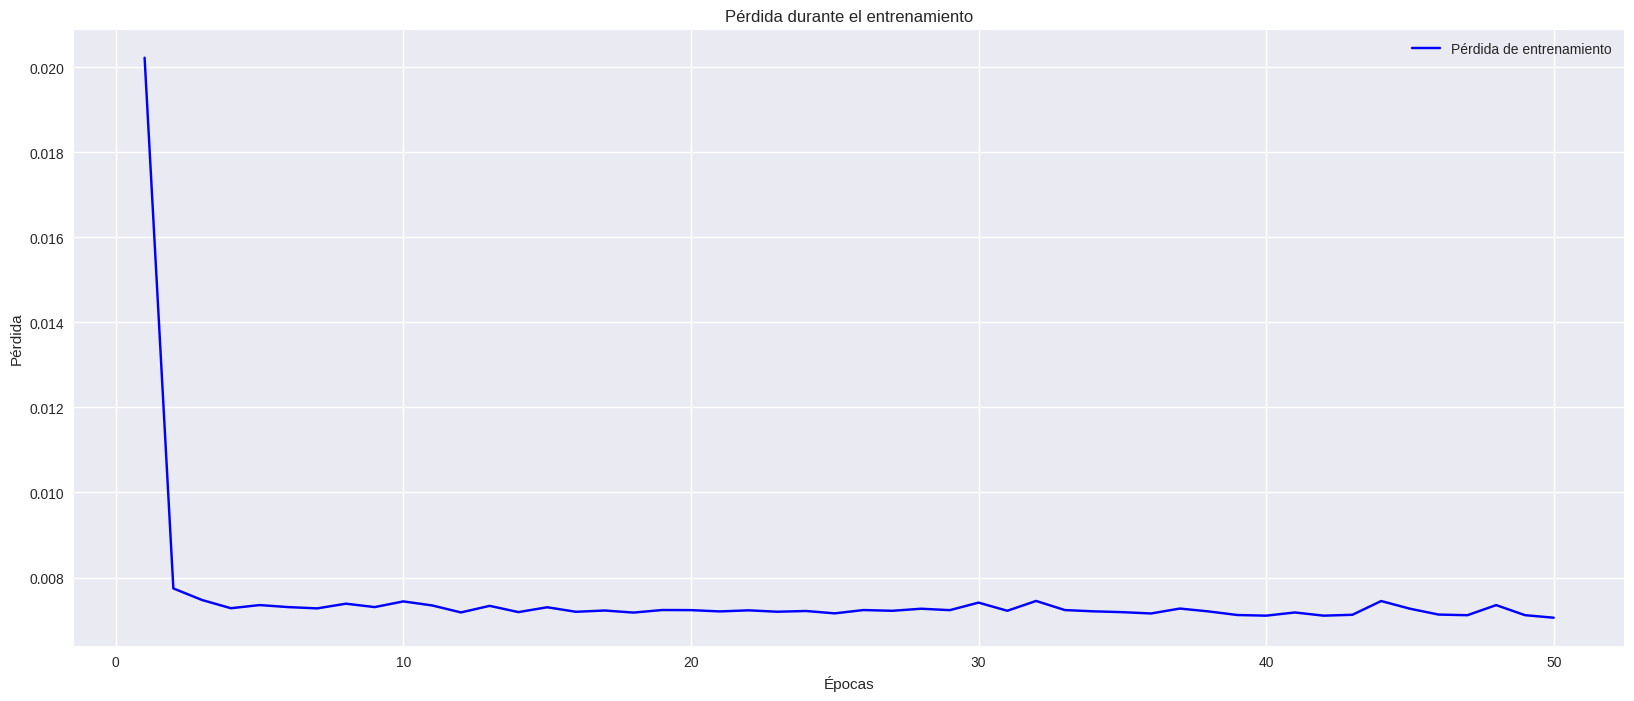

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Error cuadrático medio en el conjunto de prueba: 8279382.001172677


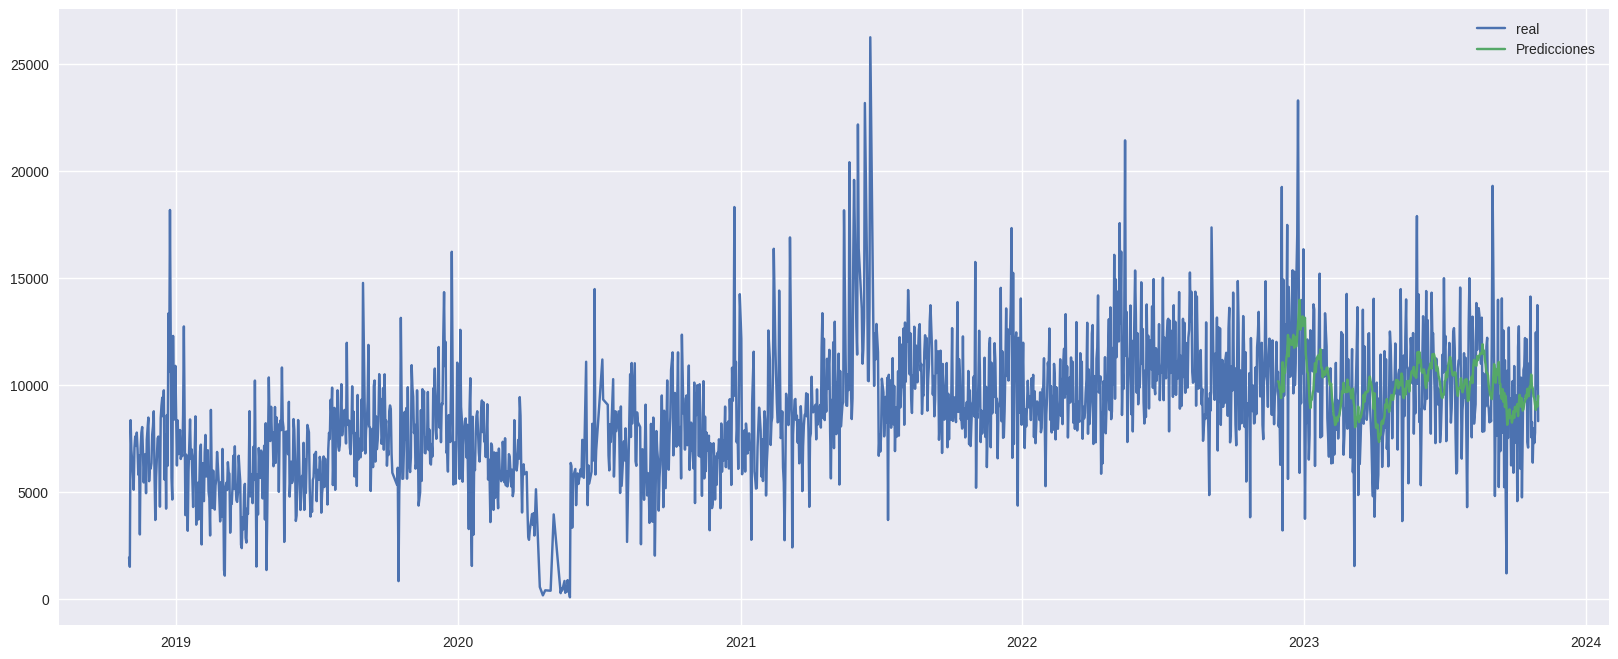

In [ ]:
# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(df_lstm['MontoBase'].values[train_size+seq_length:], predictions)
print(f"Error cuadrático medio en el conjunto de prueba: {mse}")

# Visualizar las predicciones
plt.plot(df_lstm['MontoBase'], label='real')
plt.plot(df_lstm.index[train_size+seq_length:], predictions, label='Predicciones')
plt.legend()
plt.show()

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1669, 30)
Forma de y: (1669, 1)


1/1 [==============================] - 0s 48ms/step


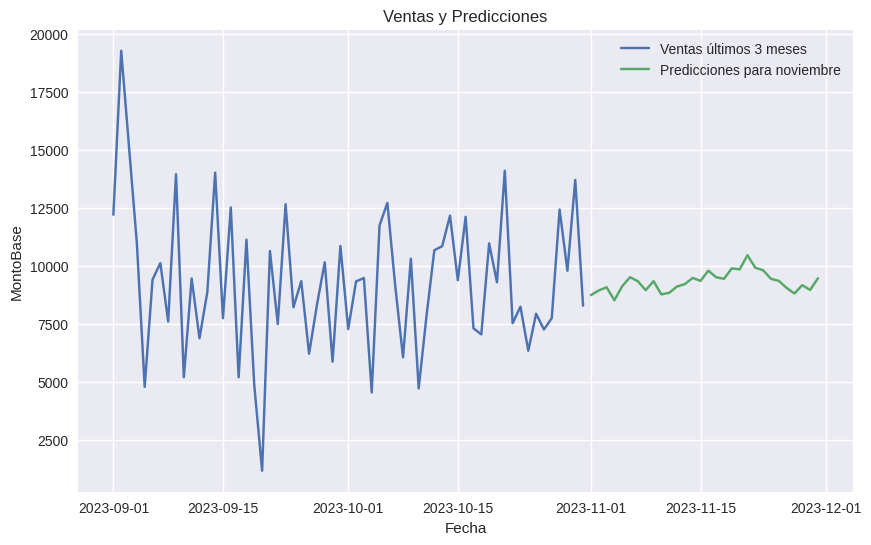

In [ ]:
# Supongamos que df_lstm tiene la columna 'FechaMovimiento' como índice
df_lstm.index = pd.to_datetime(df_lstm.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
input_data = last_3_months['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
plt.plot(dates_future, predictions_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  9332.5070       8595.6330    8753.0088
1       2023-11-02  9630.4511       9399.1706    8956.0449
2       2023-11-03  7936.0575       9711.9055    9094.6025
3       2023-11-04  8382.5270      11745.6439    8531.7070
4       2023-11-05  5534.4785       8671.9549    9139.4639
5       2023-11-06 10146.2390      10248.9363    9527.8975
6       2023-11-07  9024.6372       8241.8131    9352.0234
7       2023-11-08  6956.9346       8699.8866    8966.7021
8       2023-11-09  7042.5589       9465.6735    9357.6797
9       2023-11-10  5251.4783       9737.9864    8786.5654
10      2023-11-11  8545.1866      11729.7674    8853.3955
11      2023-11-12  7537.8548       8613.7947    9125.1797
12      2023-11-13 10254.5751      10149.4205    9227.6445
13      2023-11-14  6272.3680       8103.1374    9496.4004
14      2023-11-15  7034.2938       8525.4969    9367.7754
15      2023-11-16  8544.7383       9260.2161    9808.52

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 3614233.2311817696
MAE is : 1591.8425547395832
R2 is : -0.8372000572373897

--------------------
RMSE is : 1901.1136818143648
MAPE is : 22.461138786007982 %


## SIN 2020

In [ ]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm_sin_2020 = df_lstm_sin_2020[['FechaMovimiento', 'MontoBase']]
df_lstm_sin_2020['FechaMovimiento'] = pd.to_datetime(df_lstm_sin_2020['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm_sin_2020.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm_sin_2020['DayOW'] = df_lstm_sin_2020.index.dayofweek
df_lstm_sin_2020['Month'] = df_lstm_sin_2020.index.month
df_lstm_sin_2020['Year'] = df_lstm_sin_2020.index.year

# Ordenar el DataFrame por la fecha
df_lstm_sin_2020.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm_sin_2020)

# Normalizar los datos
scaler_2 = MinMaxScaler(feature_range=(0, 1))
df_lstm_sin_2020['MontoBase_scaler'] = scaler_2.fit_transform(df_lstm_sin_2020['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm_sin_2020['MontoBase_scaler'].values, seq_length)


# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler_2.inverse_transform(predictions_2)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1919.1250      3     11  2018
2018-11-02       1488.3740      4     11  2018
2018-11-03       8341.7180      5     11  2018
2018-11-04       6940.9740      6     11  2018
2018-11-05       6447.0630      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       7760.7466      4     10  2023
2023-10-28      12445.1841      5     10  2023
2023-10-29       9805.2984      6     10  2023
2023-10-30      13719.8369      0     10  2023
2023-10-31       8297.2566      1     10  2023

[1412 rows x 4 columns]
Epoch 1/50
35/35 - 5s - loss: 0.0262 - 5s/epoch - 132ms/step
Epoch 2/50
35/35 - 1s - loss: 0.0092 - 835ms/epoch - 24ms/step
Epoch 3/50
35/35 - 1s - loss: 0.0090 - 727ms/epoch - 21ms/step
Epoch 4/50
35/35 - 0s - loss: 0.0090 - 467ms/epoch - 13ms/step
Epoch 5/50
35/35 - 0s - loss: 0.0089 - 466ms/epoch - 13ms/step
Epoch 6/50
35/35 - 0s - loss: 0.0089 - 472ms/epoch 

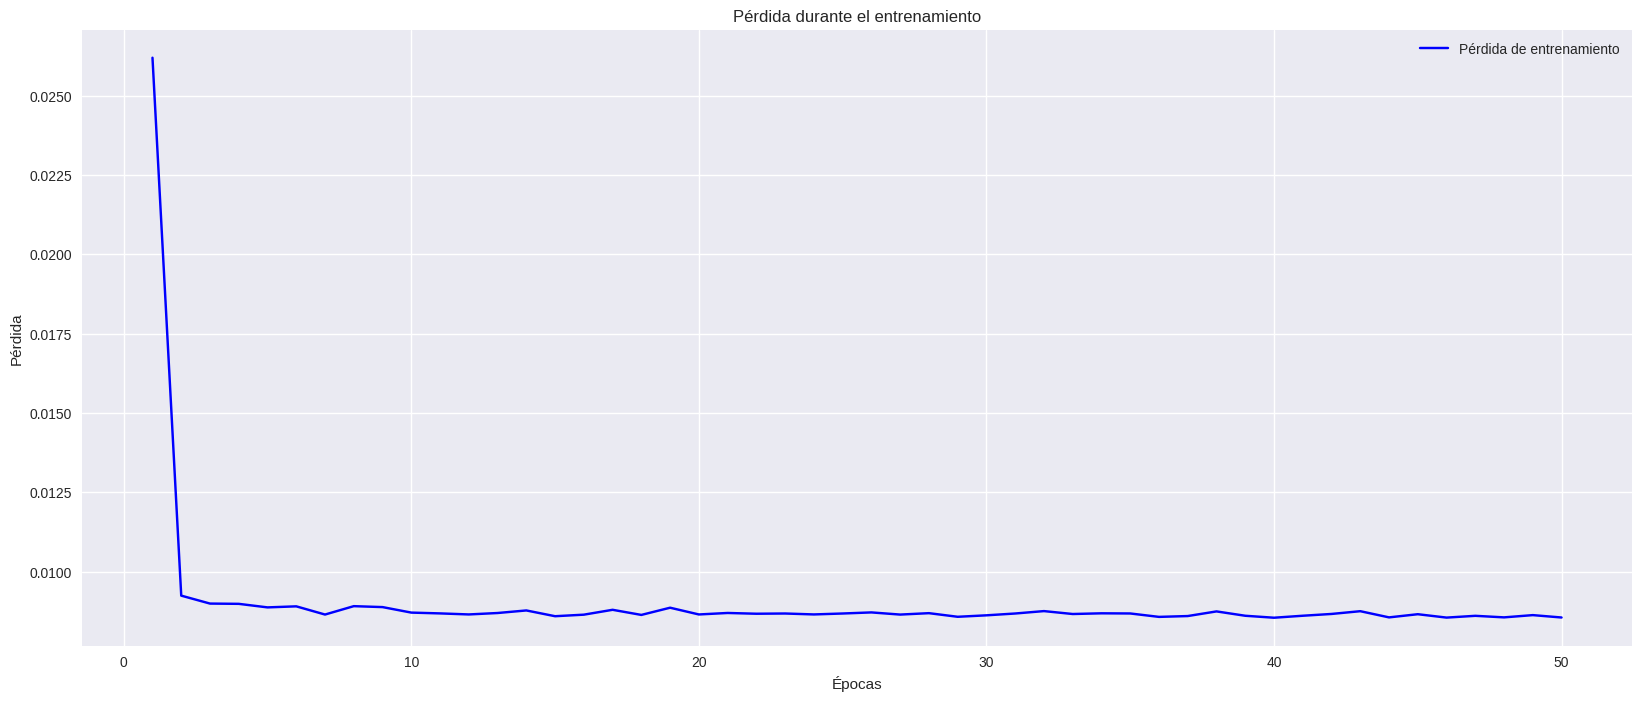

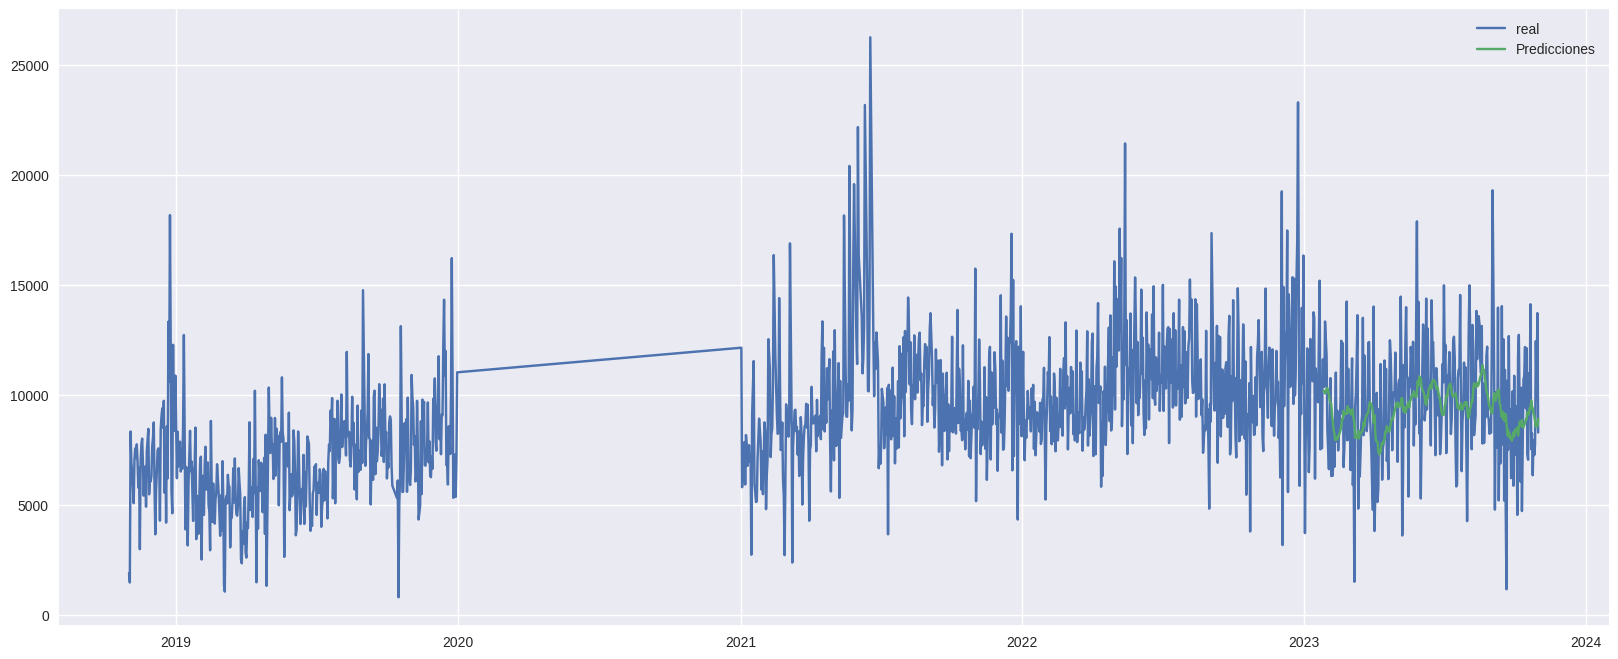

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Visualizar las predicciones
plt.plot(df_lstm_sin_2020['MontoBase'], label='real')
plt.plot(df_lstm_sin_2020.index[train_size+seq_length:], predictions_2, label='Predicciones')
plt.legend()
plt.show()


Forma de X: (1382, 30)
Forma de y: (1382, 1)
1/1 [==============================] - 0s 48ms/step


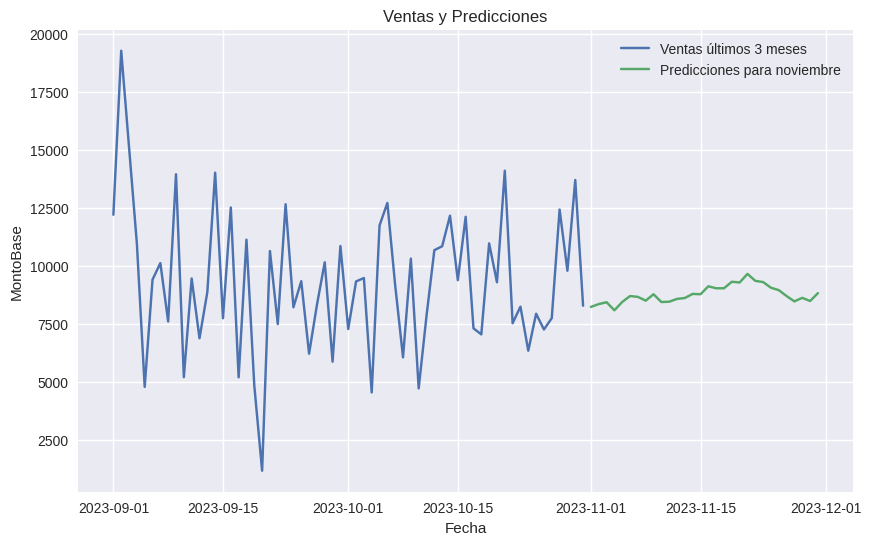

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Supongamos que df_lstm_sin_2020 tiene la columna 'FechaMovimiento' como índice
df_lstm_sin_2020.index = pd.to_datetime(df_lstm_sin_2020.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm_sin_2020[df_lstm_sin_2020.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
input_data = last_3_months['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_2_future))
plt.plot(dates_future, predictions_2_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_suma_sin_2020['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  9332.5070       8595.6330    8753.0088
1       2023-11-02  9630.4511       9399.1706    8956.0449
2       2023-11-03  7936.0575       9711.9055    9094.6025
3       2023-11-04  8382.5270      11745.6439    8531.7070
4       2023-11-05  5534.4785       8671.9549    9139.4639
5       2023-11-06 10146.2390      10248.9363    9527.8975
6       2023-11-07  9024.6372       8241.8131    9352.0234
7       2023-11-08  6956.9346       8699.8866    8966.7021
8       2023-11-09  7042.5589       9465.6735    9357.6797
9       2023-11-10  5251.4783       9737.9864    8786.5654
10      2023-11-11  8545.1866      11729.7674    8853.3955
11      2023-11-12  7537.8548       8613.7947    9125.1797
12      2023-11-13 10254.5751      10149.4205    9227.6445
13      2023-11-14  6272.3680       8103.1374    9496.4004
14      2023-11-15  7034.2938       8525.4969    9367.7754
15      2023-11-16  8544.7383       9260.2161    9808.52

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 3614233.2311817696
MAE is : 1591.8425547395832
R2 is : -0.8372000572373897

--------------------
RMSE is : 1901.1136818143648
MAPE is : 22.461138786007982 %


# ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
df_todo_hasta_nov_prophet.head

<bound method NDFrame.head of               ds          y
0     2018-11-01  1919.1250
1     2018-11-02  1488.3740
2     2018-11-03  8341.7180
3     2018-11-04  6940.9740
4     2018-11-05  6447.0630
...          ...        ...
1694  2023-10-27  7760.7466
1695  2023-10-28 12445.1841
1696  2023-10-29  9805.2984
1697  2023-10-30 13719.8369
1698  2023-10-31  8297.2566

[1699 rows x 2 columns]>

## CON 2020

In [ ]:
df_arima = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       1919.1250
2018-11-02       1488.3740
2018-11-03       8341.7180
2018-11-04       6940.9740
2018-11-05       6447.0630
...                    ...
2023-10-27       7760.7466
2023-10-28      12445.1841
2023-10-29       9805.2984
2023-10-30      13719.8369
2023-10-31       8297.2566

[1699 rows x 1 columns]>


In [ ]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1699 entries, 2018-11-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1699 non-null   float64
dtypes: float64(1)
memory usage: 26.5+ KB


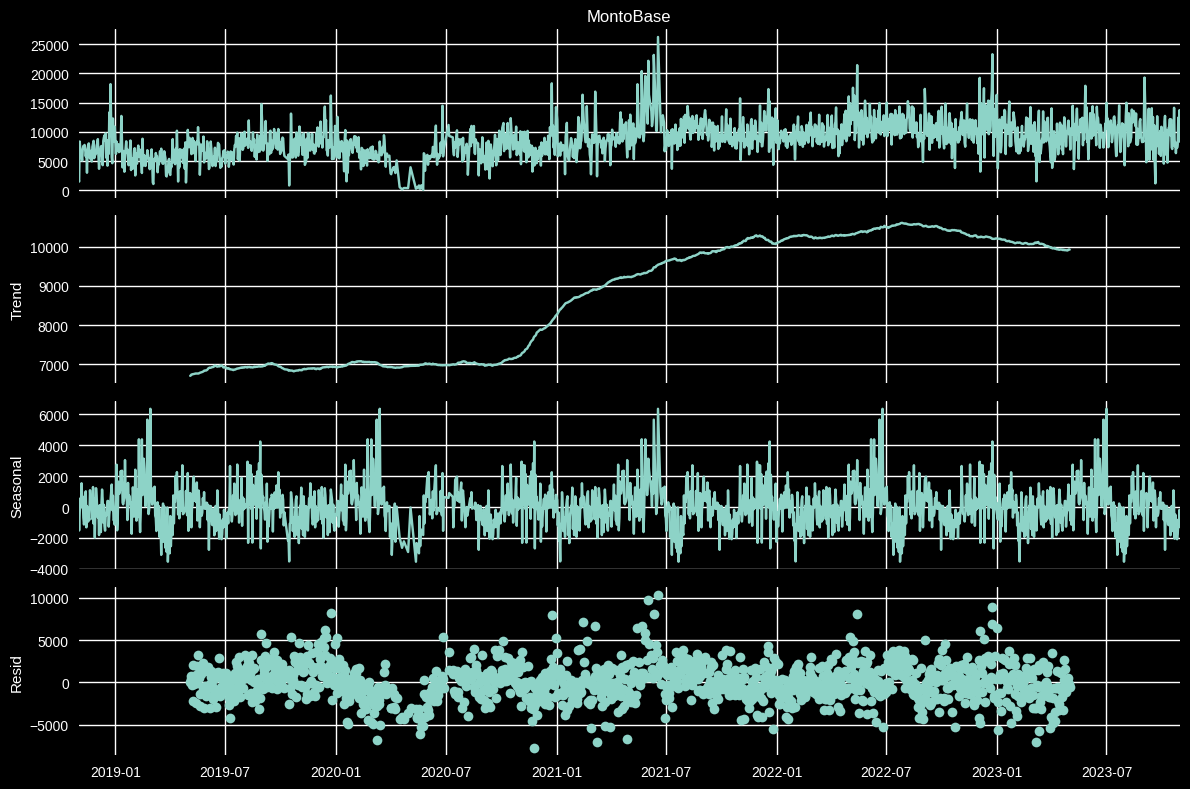

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-01,1919.1250
2018-11-02,1488.3740
2018-11-03,8341.7180
2018-11-04,6940.9740
2018-11-05,6447.0630
...,...
2023-10-27,7760.7466
2023-10-28,12445.1841
2023-10-29,9805.2984


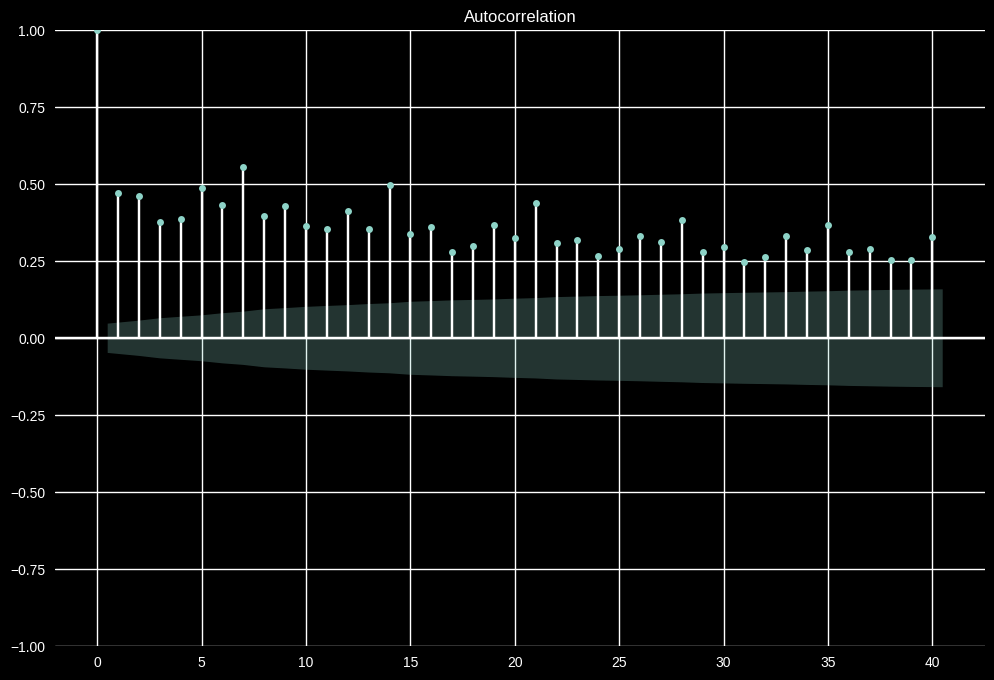

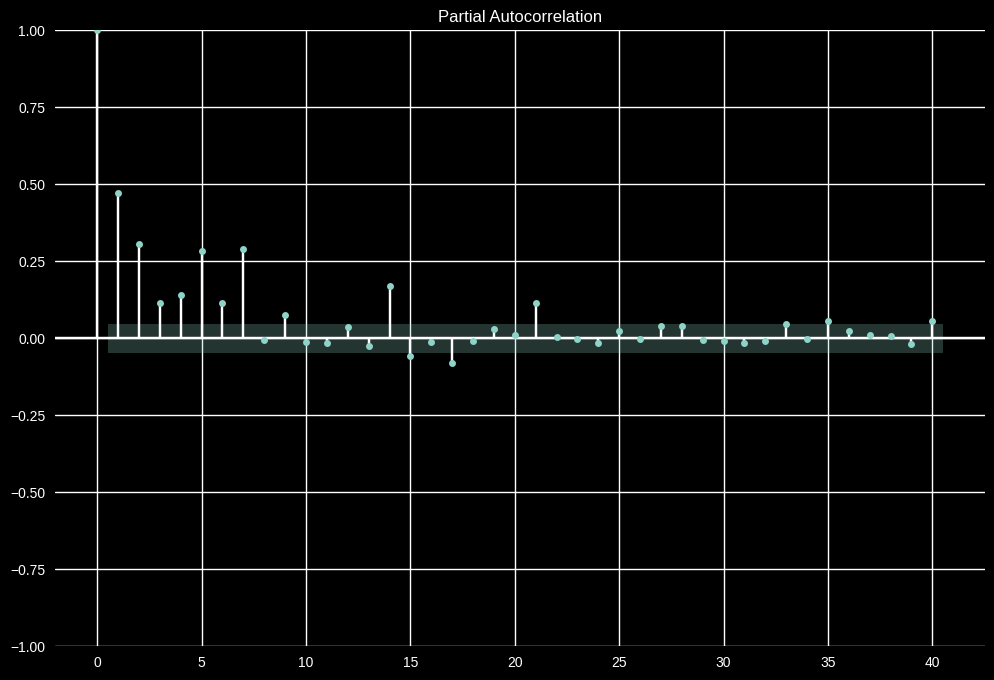

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
plt.style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
plt.show()

plot_pacf(df_arima['MontoBase'], lags=40)
plt.show()

In [ ]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


In [ ]:
train.shape, test.shape

((1668, 1), (31, 1))

In [ ]:
# Modelo Auto-Arima
from pmdarima import auto_arima

In [ ]:
# modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
#           max_p=4,max_d=2,max_q=4, start_P=0,
#           D=1, start_Q=0, max_P=2,max_D=1,
#           max_Q=2, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# se tiene el problema de q se usa toda la memoria RAM 12.7GB

In [ ]:
# print(modelo_auto.summary())

implementación del modelo

In [ ]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-01       1919.1250
2018-11-02       1488.3740
2018-11-03       8341.7180
2018-11-04       6940.9740
2018-11-05       6447.0630
...                    ...
2023-09-26       6227.2406
2023-09-27       8329.1051
2023-09-28      10170.9582
2023-09-29       5882.9167
2023-09-30      10872.2644

[1668 rows x 1 columns]


In [ ]:
# plt.style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# plt.show()

In [ ]:
# arima_model = SARIMAX(train["MontoBase"], order = (3,1,1), seasonal_order = (2,1,0,12))
arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1668
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 12)   Log Likelihood              -15495.405
Date:                             Fri, 22 Dec 2023   AIC                          31006.811
Time:                                     22:50:29   BIC                          31050.103
Sample:                                          0   HQIC                         31022.860
                                            - 1668                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1663      0.053     -3.160      0.002      -0.270      -0.063
ar.L2         -0.1059      0.043     -2.462      0.014      -0.190      -0.022
ar.L3         -0.2454      0.038     -6.490      0.000      -0.320      -0.171
ar.L4         -0.2126      0.041     -5.220      0.000      -0.292      -0.133
ma.L1         -0.6744      0.047    -14.438      0.000      -0.766      -0.583
ar.S.L12      -0.6250      0.030    -20.604      0.000      -0.684      -0.566
ar.S.L24      -0.3378      0.036     -9.410      0.000      -0.408      -0.267
sigma2      1.127e+07   4.64e+05     24.292      0.000    1.04e+07    1.22e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               126.15
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [ ]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1668    7170.5797
1669    4799.5298
1670    9132.9534
1671    5727.1172
1672    9233.7463
1673    6912.4611
1674    7647.6366
1675    9099.8810
1676   10409.0297
1677    9739.4953
1678    4006.7623
1679    9180.7263
1680    6210.0989
1681    3379.9682
1682    9856.5604
1683    4720.9428
1684    8971.7723
1685    5961.7376
1686    7231.9738
1687    8614.5874
1688    7584.1608
1689    9475.3093
1690    3621.2557
1691    9001.3438
1692    4701.1847
1693    1716.3773
1694    8589.4324
1695    4620.9142
1696    8968.1591
1697    5671.7126
1698    6739.5099
Name: ARIMA_Predictions, dtype: float64

In [ ]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01    7170.5797
2023-10-02    4799.5298
2023-10-03    9132.9534
2023-10-04    5727.1172
2023-10-05    9233.7463
2023-10-06    6912.4611
2023-10-07    7647.6366
2023-10-08    9099.8810
2023-10-09   10409.0297
2023-10-10    9739.4953
2023-10-11    4006.7623
2023-10-12    9180.7263
2023-10-13    6210.0989
2023-10-14    3379.9682
2023-10-15    9856.5604
2023-10-16    4720.9428
2023-10-17    8971.7723
2023-10-18    5961.7376
2023-10-19    7231.9738
2023-10-20    8614.5874
2023-10-21    7584.1608
2023-10-22    9475.3093
2023-10-23    3621.2557
2023-10-24    9001.3438
2023-10-25    4701.1847
2023-10-26    1716.3773
2023-10-27    8589.4324
2023-10-28    4620.9142
2023-10-29    8968.1591
2023-10-30    5671.7126
2023-10-31    6739.5099
Name: ARIMA_Predictions, dtype: float64


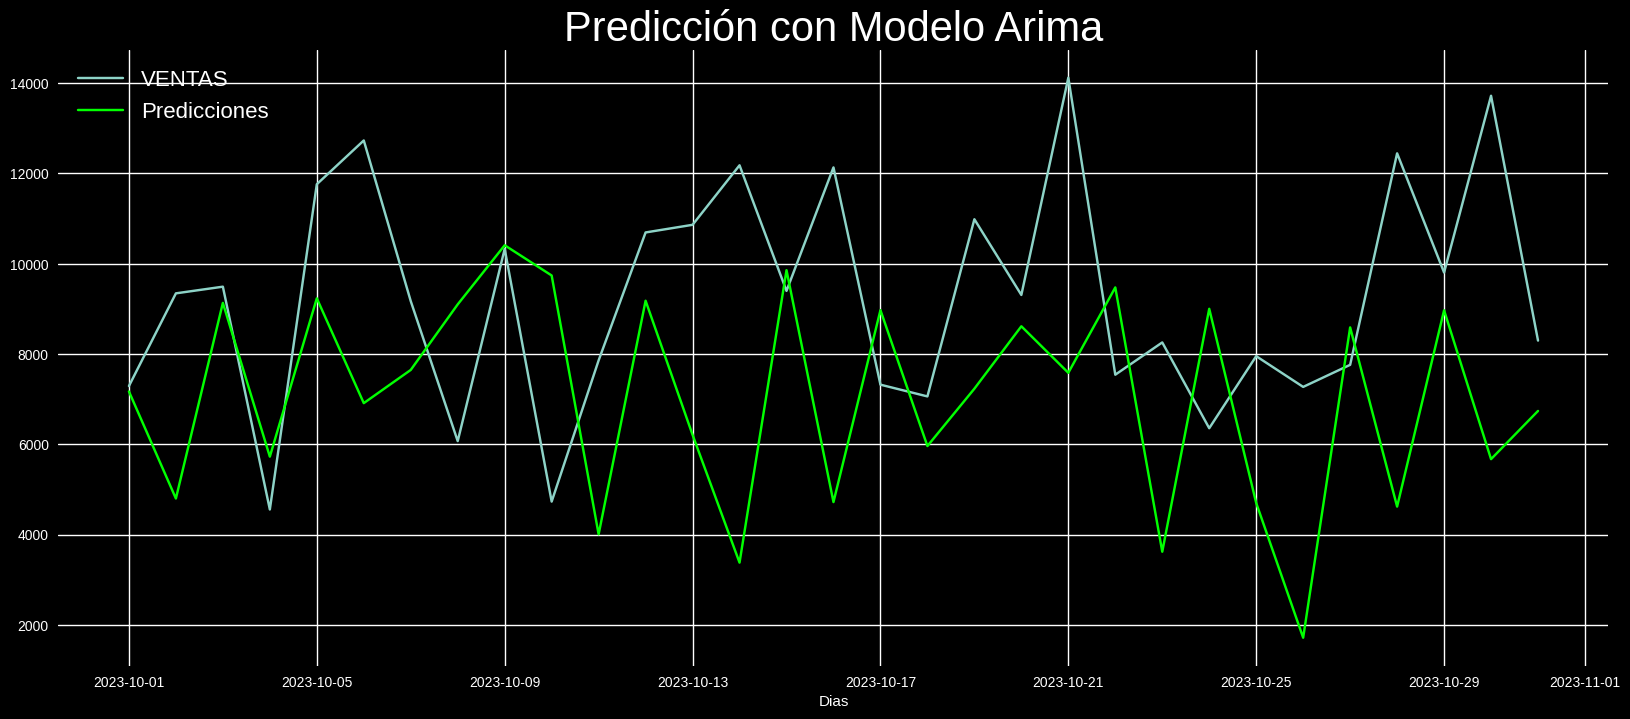

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test["MontoBase"], label="VENTAS")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [ ]:
arima_pred2 = arima_result.predict(start = 1699,end=1728, typ="levels").rename("ARIMA Predictions")
arima_pred2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1699   6618.4165
1700   7317.9155
1701   8456.7784
1702   3166.5356
1703   8355.4796
1704   4639.4154
1705   1906.3581
1706   7807.6851
1707   3693.9640
1708   7729.5680
1709   4844.7847
1710   5858.3877
1711   6700.6701
1712   7109.1767
1713   7853.2940
1714   2251.6335
1715   7490.4235
1716   3858.3721
1717   1020.2120
1718   7394.9764
1719   2977.7911
1720   7175.6109
1721   4130.2714
1722   5246.1264
1723   5994.1933
1724   6000.2486
1725   7245.1958
1726   1647.7366
1727   6919.9357
1728   3038.0806
Name: ARIMA Predictions, dtype: float64

In [ ]:
print(df_noviembre_sumaT.head())
df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  9332.5070       8595.6330    8753.0088
1      2023-11-02  9630.4511       9399.1706    8956.0449
2      2023-11-03  7936.0575       9711.9055    9094.6025
3      2023-11-04  8382.5270      11745.6439    8531.7070
4      2023-11-05  5534.4785       8671.9549    9139.4639
                 MontoBase  Ventas_PROPHET  Ventas_LSTM
FechaMovimiento                                        
2023-11-01       9332.5070       8595.6330    8753.0088
2023-11-02       9630.4511       9399.1706    8956.0449
2023-11-03       7936.0575       9711.9055    9094.6025
2023-11-04       8382.5270      11745.6439    8531.7070
2023-11-05       5534.4785       8671.9549    9139.4639


In [ ]:
arima_pred2.index = df_noviembre_sumaT.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred2)

FechaMovimiento
2023-11-01   6618.4165
2023-11-02   7317.9155
2023-11-03   8456.7784
2023-11-04   3166.5356
2023-11-05   8355.4796
2023-11-06   4639.4154
2023-11-07   1906.3581
2023-11-08   7807.6851
2023-11-09   3693.9640
2023-11-10   7729.5680
2023-11-11   4844.7847
2023-11-12   5858.3877
2023-11-13   6700.6701
2023-11-14   7109.1767
2023-11-15   7853.2940
2023-11-16   2251.6335
2023-11-17   7490.4235
2023-11-18   3858.3721
2023-11-19   1020.2120
2023-11-20   7394.9764
2023-11-21   2977.7911
2023-11-22   7175.6109
2023-11-23   4130.2714
2023-11-24   5246.1264
2023-11-25   5994.1933
2023-11-26   6000.2486
2023-11-27   7245.1958
2023-11-28   1647.7366
2023-11-29   6919.9357
2023-11-30   3038.0806
Name: ARIMA Predictions, dtype: float64


<ipython-input-232-2a97b7cdadf6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


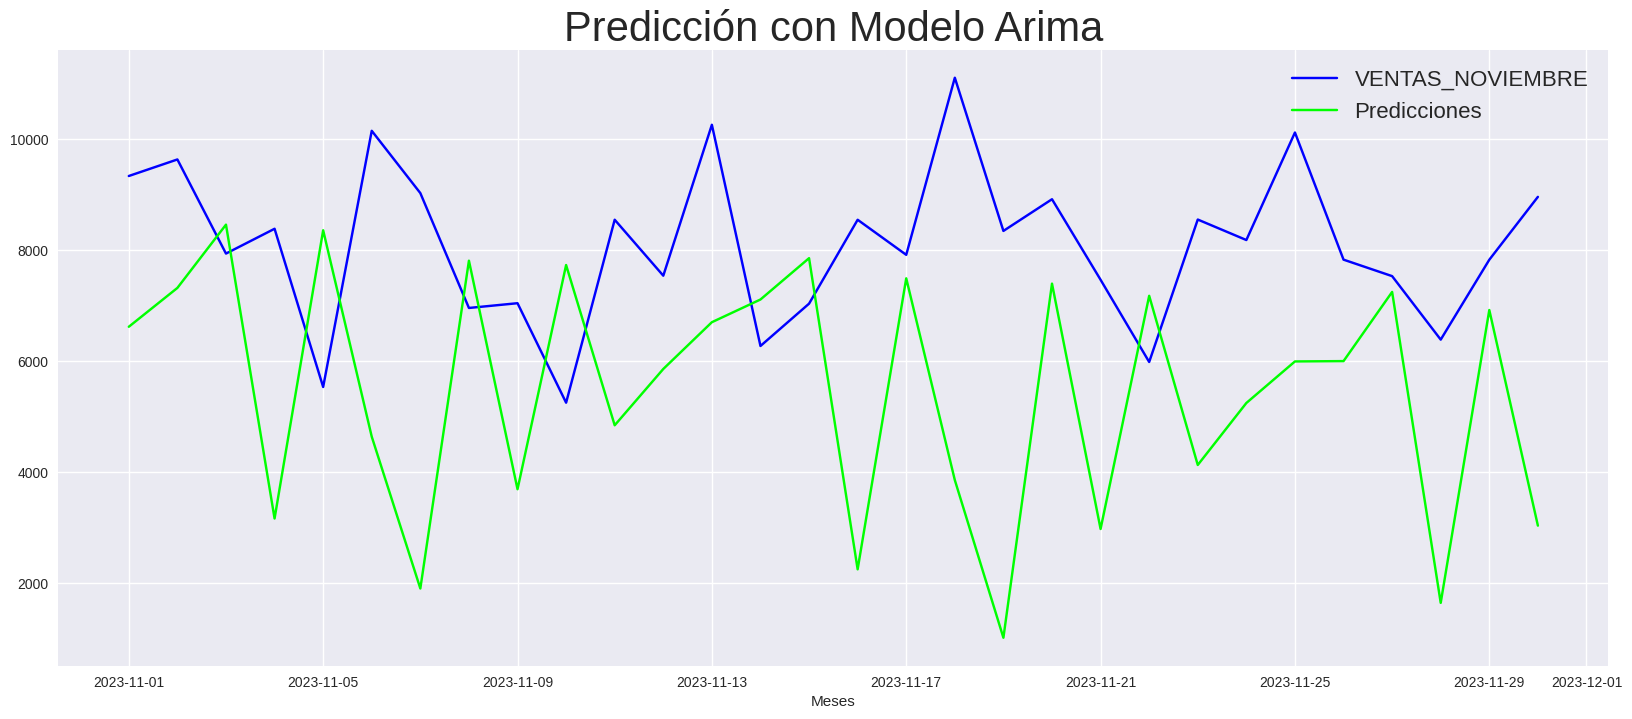

In [ ]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

#plt.plot(test["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_sumaT["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar


In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       9332.5070       8595.6330    8753.0088     6618.4165
2023-11-02       9630.4511       9399.1706    8956.0449     7317.9155
2023-11-03       7936.0575       9711.9055    9094.6025     8456.7784
2023-11-04       8382.5270      11745.6439    8531.7070     3166.5356
2023-11-05       5534.4785       8671.9549    9139.4639     8355.4796
2023-11-06      10146.2390      10248.9363    9527.8975     4639.4154
2023-11-07       9024.6372       8241.8131    9352.0234     1906.3581
2023-11-08       6956.9346       8699.8866    8966.7021     7807.6851
2023-11-09       7042.5589       9465.6735    9357.6797     3693.9640
2023-11-10       5251.4783       9737.9864    8786.5654     7729.5680
2023-11-11       8545.1866      11729.7674    8853.3955     4844.7847
2023-11-12       7537.8548       8613.7947    9125.1797     5858.3877
2023-11-13      1025

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 15144153.700402688
MAE is : 3236.829931831094
R2 is : -6.698130769522649

--------------------
RMSE is : 3891.549010407384
MAPE is : 39.150854208024235 %


## SIN el 2020

In [ ]:
df_arima_sin_2020 = df_todo_hasta_nov_sin_2020_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima_sin_2020.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima_sin_2020.dtypes)
print(df_arima_sin_2020.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       1919.1250
2018-11-02       1488.3740
2018-11-03       8341.7180
2018-11-04       6940.9740
2018-11-05       6447.0630
...                    ...
2023-10-27       7760.7466
2023-10-28      12445.1841
2023-10-29       9805.2984
2023-10-30      13719.8369
2023-10-31       8297.2566

[1412 rows x 1 columns]>


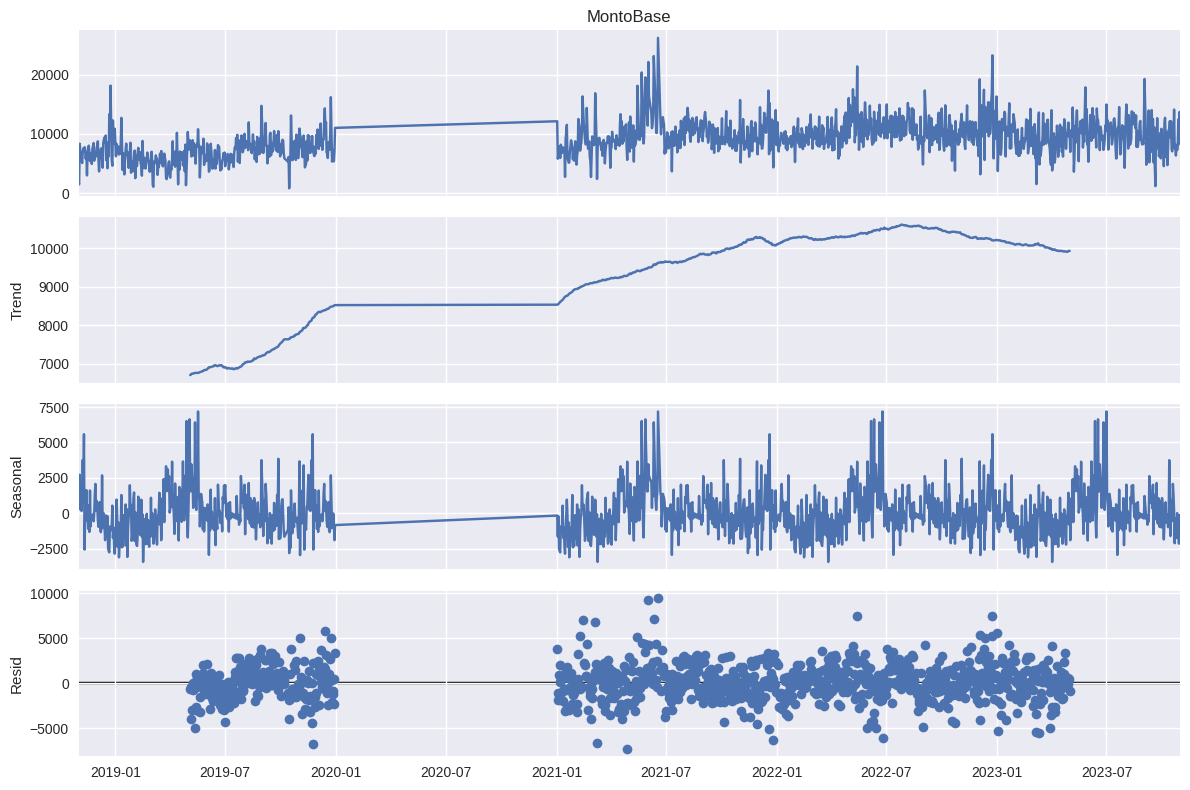

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_sin_2020["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_s20 = int(len(df_arima_sin_2020) - 31)
train_s20, test_s20 = df_arima_sin_2020[0:train_size_s20], df_arima_sin_2020[train_size_s20:]

In [ ]:
train_s20.shape, test_s20.shape

((1381, 1), (31, 1))

In [ ]:
print(train_s20)

                 MontoBase
FechaMovimiento           
2018-11-01       1919.1250
2018-11-02       1488.3740
2018-11-03       8341.7180
2018-11-04       6940.9740
2018-11-05       6447.0630
...                    ...
2023-09-26       6227.2406
2023-09-27       8329.1051
2023-09-28      10170.9582
2023-09-29       5882.9167
2023-09-30      10872.2644

[1381 rows x 1 columns]


In [ ]:
arima_model_s20 = SARIMAX(train_s20["MontoBase"], order = (3,1,1), seasonal_order = (2,1,0,12))
arima_result_s20 = arima_model_s20.fit()
arima_result_s20.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1381
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood              -12795.212
Date:                             Fri, 22 Dec 2023   AIC                          25604.424
Time:                                     22:51:18   BIC                          25640.972
Sample:                                          0   HQIC                         25618.103
                                            - 1381                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0018      0.028      0.062      0.950      -0.054       0.057
ar.L2          0.0012      0.027      0.044      0.965      -0.051       0.054
ar.L3         -0.1878      0.027     -6.907      0.000      -0.241      -0.134
ma.L1         -0.8439      0.019    -44.472      0.000      -0.881      -0.807
ar.S.L12      -0.6161      0.021    -28.994      0.000      -0.658      -0.574
ar.S.L24      -0.3468      0.026    -13.404      0.000      -0.397      -0.296
sigma2      7.769e+06   2.42e+05     32.125      0.000     7.3e+06    8.24e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):               100.54
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:

arima_pred_s20 = arima_result_s20.predict(start = 1381,end=1410, typ="levels").rename("ARIMA Predictions sin 2020")
arima_pred_s20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1381    7028.6015
1382    5122.3974
1383    9103.2750
1384    5968.8218
1385    8860.0645
1386    6650.5063
1387    7404.8923
1388    8958.0844
1389   10516.5298
1390    9645.4820
1391    3880.6359
1392    9000.6238
1393    6076.3219
1394    3480.4932
1395    9763.1654
1396    4676.6350
1397    8654.8215
1398    5715.0079
1399    6996.9377
1400    8538.6476
1401    7525.5681
1402    9343.8224
1403    3435.4298
1404    8803.1671
1405    4465.3410
1406    1680.3955
1407    8450.2786
1408    4560.7926
1409    8659.0940
1410    5394.1085
Name: ARIMA Predictions sin 2020, dtype: float64

In [ ]:
arima_pred_s20.index = df_noviembre_suma_sin_2020.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred_s20)

FechaMovimiento
2023-11-01    7028.6015
2023-11-02    5122.3974
2023-11-03    9103.2750
2023-11-04    5968.8218
2023-11-05    8860.0645
2023-11-06    6650.5063
2023-11-07    7404.8923
2023-11-08    8958.0844
2023-11-09   10516.5298
2023-11-10    9645.4820
2023-11-11    3880.6359
2023-11-12    9000.6238
2023-11-13    6076.3219
2023-11-14    3480.4932
2023-11-15    9763.1654
2023-11-16    4676.6350
2023-11-17    8654.8215
2023-11-18    5715.0079
2023-11-19    6996.9377
2023-11-20    8538.6476
2023-11-21    7525.5681
2023-11-22    9343.8224
2023-11-23    3435.4298
2023-11-24    8803.1671
2023-11-25    4465.3410
2023-11-26    1680.3955
2023-11-27    8450.2786
2023-11-28    4560.7926
2023-11-29    8659.0940
2023-11-30    5394.1085
Name: ARIMA Predictions sin 2020, dtype: float64


                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       9332.5070       8351.0707    8245.0977           NaN
2023-11-02       9630.4511       9208.3682    8367.6211           NaN
2023-11-03       7936.0575       9562.0162    8448.6514           NaN
2023-11-04       8382.5270      11759.6584    8099.1470           NaN
2023-11-05       5534.4785       8446.6696    8458.8506           NaN


<ipython-input-248-3b5fc85ea121>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


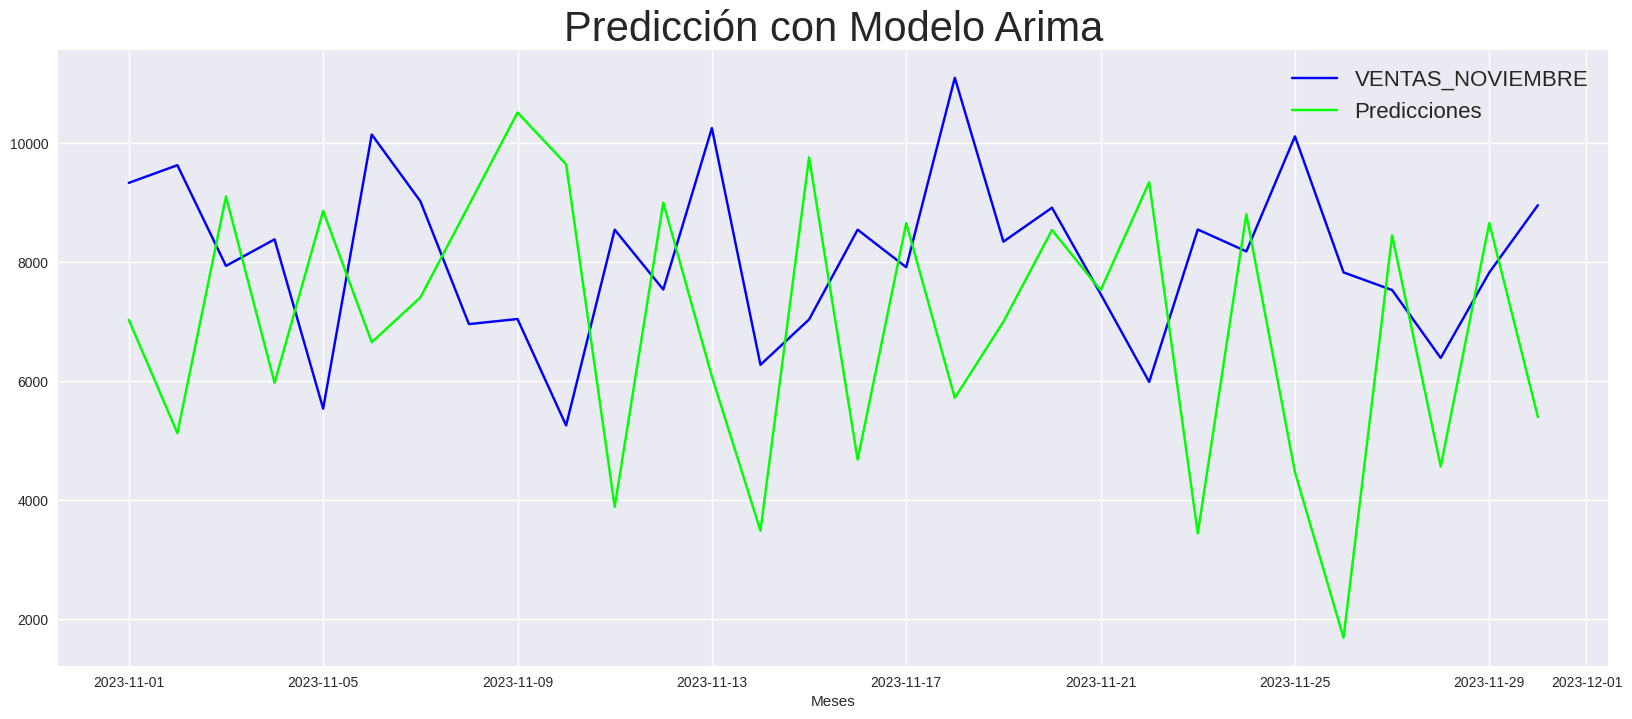

In [ ]:
print(df_noviembre_suma_sin_2020.head())
df_noviembre_suma_sin_2020.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_suma_sin_2020.head())

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)
#plt.plot(test_s20["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_suma_sin_2020["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred_s20, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar

In [ ]:
# PARA ELIMINAR LA COLUMNA CON VALORES 'NaN'
# print(df_noviembre_suma_sin_2020)
# df_noviembre_suma_sin_2020.drop(columns=['Ventas_ARIMA'], inplace=True)
# print(df_noviembre_suma_sin_2020)

                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       9332.5070       8351.0707    8245.0977           NaN
2023-11-02       9630.4511       9208.3682    8367.6211           NaN
2023-11-03       7936.0575       9562.0162    8448.6514           NaN
2023-11-04       8382.5270      11759.6584    8099.1470           NaN
2023-11-05       5534.4785       8446.6696    8458.8506           NaN
2023-11-06      10146.2390      10031.9297    8714.5635           NaN
2023-11-07       9024.6372       7992.9822    8679.2373           NaN
2023-11-08       6956.9346       8547.3578    8515.0322           NaN
2023-11-09       7042.5589       9373.1661    8792.0039           NaN
2023-11-10       5251.4783       9693.3231    8456.5713           NaN
2023-11-11       8545.1866      11856.5347    8469.8799           NaN
2023-11-12       7537.8548       8509.2911    8590.9111           NaN
2023-11-13      1025

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_suma_sin_2020['Ventas_ARIMA'] = arima_pred_s20

# Imprimir el resultado
print(df_noviembre_suma_sin_2020.head(20))

                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       9332.5070       8351.0707    8245.0977     7028.6015
2023-11-02       9630.4511       9208.3682    8367.6211     5122.3974
2023-11-03       7936.0575       9562.0162    8448.6514     9103.2750
2023-11-04       8382.5270      11759.6584    8099.1470     5968.8218
2023-11-05       5534.4785       8446.6696    8458.8506     8860.0645
2023-11-06      10146.2390      10031.9297    8714.5635     6650.5063
2023-11-07       9024.6372       7992.9822    8679.2373     7404.8923
2023-11-08       6956.9346       8547.3578    8515.0322     8958.0844
2023-11-09       7042.5589       9373.1661    8792.0039    10516.5298
2023-11-10       5251.4783       9693.3231    8456.5713     9645.4820
2023-11-11       8545.1866      11856.5347    8469.8799     3880.6359
2023-11-12       7537.8548       8509.2911    8590.9111     9000.6238
2023-11-13      1025

In [ ]:
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 10742789.083854252
MAE is : 2811.5320750991314
R2 is : -4.460813250641496

--------------------
RMSE is : 3277.6194232787693
MAPE is : 35.361557668397396 %


## TODAS LAS EVALUACIONES

In [ ]:
print("--"*10,"EVALUACIÓN CON 2020","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN SIN 2020","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON 2020 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 3078152.135372517
MAE is : 1359.817739524297
R2 is : -0.5646973832517912 %
------------------------------
RMSE is : 1754.4663391962006
MAPE is : 19.19058256254281 %
------------------------------
---------- LSTM ----------
Evaluation metric results:-
MSE is : 3614233.2311817696
MAE is : 1591.8425547395832
R2 is : -0.8372000572373897 %
------------------------------
RMSE is : 1901.1136818143648
MAPE is : 22.461138786007982 %
------------------------------
---------- ARIMA ----------
Evaluation metric results:-
MSE is : 15144153.700402688
MAE is : 3236.829931831094
R2 is : -6.698130769522649 %
------------------------------
RMSE is : 3891.549010407384
MAPE is : 39.150854208024235 %
------------------------------
-------------------- EVALUACIÓN SIN 2020 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 3290456.396026234
MAE 